*Markov chain Monte Carlo* methods can be used to sample from posterior probability distribution where the marginal model is intractable but likelihood evaluation is possible. For our purposes, we are going to use it in order to validate the *approximate posterior* distribution obtained with variational inference in the [precedent notebook](https://github.com/CosmoStat/jax-lensing/blob/master/notebooks/multivariate_gaussian_vi.ipynb).

*Metropolis-Hasting* algotithm is used for automaticaly constructing appropriate transition for any given target distribution. It consists of two steps: 1) proposes a next state, let $q(\kappa'|\kappa)$ be the probability density defining each proposal, and 2) rejects any proposal that stray too far from the typical set of target distribution. The probability of accepting a transition $\kappa \rightarrow \kappa'$ is given by the acceptence ratio: $$a(\kappa'|\kappa) = \left(1, \frac{q(\kappa'|\kappa)}{q(\kappa|\kappa')} \frac{p(\kappa')p(\gamma|\kappa')}{p(\kappa)p(\gamma|\kappa)} \right),$$

where $p(\kappa)$ is the prior distrubution of the convergence map and $p(\gamma|\kappa)$ is the likelihood distribution.

*Random walk metropolis* uses a Gaussian distribution as its proposal mechanism, such that $q(\kappa'|\kappa) \sim \mathcal{N}(\kappa'|\kappa, \Sigma)$. This leads to a simple form of the acceptance probability because of the symetry, but it performs poorly with increasing dimension and complexity of target distribution.

**Hamiltonian Monte Carlo** improves this method by modeling the target distribution as a potential energy function $U(\kappa)=-\log\left[p(\gamma|\kappa)p(\kappa)\right]$, and introducing a kinetic energy $K$ (Euclidian-Gaussian kinetic energy for instance $K = \frac{m^Tm}{2}$) with momentum $m$. Then, the *leapfrog integrator* is used to smulates the exact trajectory of $(\kappa, m)$ as a function of $\nabla_{\kappa}U$. Eventually, the acceprance ratio of the Metropolis update becomes:

$$a(\kappa'|\kappa) = \min \left( 1, \exp\left( -U(\kappa') + U(\kappa) - K(m') + K(m) \right) \right)$$

References: [Neal (2011)](https://arxiv.org/abs/1206.1901), [Betancourt (2017)](https://arxiv.org/abs/1701.02434)

In [1]:
#@title Run this cell if this notebook is on colab

%%capture
!git clone https://github.com/CosmoStat/jax-lensing.git
import os
os.chdir('jax-lensing')
!pip install .
os.chdir('..')
!git clone https://github.com/austinpeel/lenspack.git
os.chdir('lenspack')
!pip install .
os.chdir('..')

In [2]:
import matplotlib.pyplot as plt
import jax
from jax_lensing.inversion import ks93inv
from lenspack.utils import bin2d
from astropy.table import Table
# Import the galaxy catalog
cat = Table.read('./jax-lensing/data/gal_cat.fits')
# Bin ellipticity components based on galaxy position into a 128 x 128 map
e1map, e2map = bin2d(cat['ra'], cat['dec'], v=(-cat['gamma1'], -cat['gamma2']), npix=128)

import jax.numpy as np

shear = np.stack([e1map, e2map]).flatten()

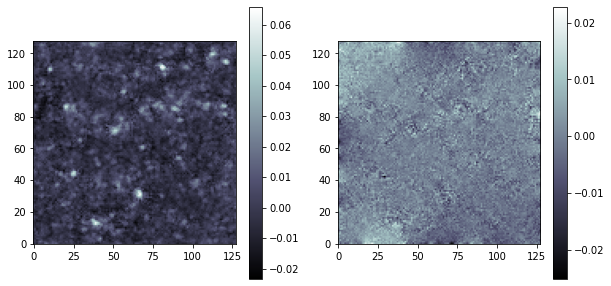

In [3]:
from jax_lensing.inversion import ks93
kappaE, kappaB = ks93(e1map, e2map)

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kappaE, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kappaB, origin='lower', cmap='bone')
plt.colorbar()

true_kappa = np.stack([kappaE, kappaB]).flatten()
true_std = 0.0001*np.ones(128*128*2)

Before running the mcmc, we would like to know the range of the shear and the convergence values in order to set smart prior and likelihood. We therefore plot the histograms of both the shear and the convergence of our toy example.

As the standard deviation of the histograms are both aroud 0.006, we round the standard deviation of the prior and the likelihood at 0.01 (we get better results than setting the standard deviations at 1).


Convergence histogram
mean 0.0
std 0.006416811
max 0.06580218
Convergence histogram
mean -0.0006669579
std 0.0065818084
max 0.04603485


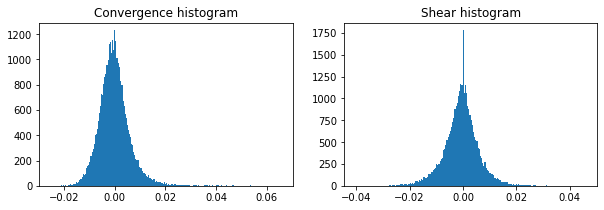

In [4]:
plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.hist(true_kappa, bins='auto')
plt.title('Convergence histogram')
print('Convergence histogram')
print('mean', np.mean(true_kappa))
print('std', np.std(true_kappa))
print('max', np.max(true_kappa))

plt.subplot(122)
plt.hist(shear, bins='auto')
plt.title('Shear histogram')
print('Convergence histogram')
print('mean', np.mean(shear))
print('std', np.std(shear))
print('max', np.max(shear))

plt.show()

To deal with missing data in the shear images, we enforce a high variance in the corresponding location.

In [5]:
coef = .01
uncertainity_mask1, uncertainity_mask2 = coef*np.ones(e1map.shape), coef*np.ones(e2map.shape)
uncertainity_mask1 = jax.ops.index_update(uncertainity_mask1, jax.ops.index[59:70, 59:70], 1e3)
uncertainity_mask2 = jax.ops.index_update(uncertainity_mask2, jax.ops.index[59:70, 59:70], 1e3)

In [6]:
!pip install --quiet --no-dependencies numpyro

import jax
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed, trace, condition, substitute
from numpyro import sample

     |████████████████████████████████| 163kB 2.7MB/s 


In [7]:
def model():
    # Let's define possible ranges for the parameters
    z = sample('z', dist.Normal(loc=0., scale=.01), sample_shape=(128*128*2,)) #prior on z
    
    # Compute the Kaisr-Squires transformation
    z1, z2 = z[:z.shape[0]//2], z[z.shape[0]//2:]
    kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
    gamma1, gamma2 = ks93inv(kE, kB)
    #gamma1 = mask1 * gamma1
    #gamma2 = mask2 * gamma2

    mean = np.stack([gamma1,gamma2], axis=0).flatten()
    std = np.stack([uncertainity_mask1,uncertainity_mask2], axis=0).flatten()

    # Here we define our model
    return sample('y', dist.Normal(loc=mean, scale=std))

# Before being able to take random draws we must initialize a seed
rng_key = jax.random.PRNGKey(0)
model = seed(model, rng_key)

In [8]:
# Sampling some y from this model
y_mod =  model()

In [9]:
print(y_mod.shape)

(32768,)


In [10]:
from numpyro.infer.util import log_density

In [11]:
# Now we can try to sample the model at the true parameters
true_model = substitute(model, {'z': true_kappa})#, 'std': true_std})

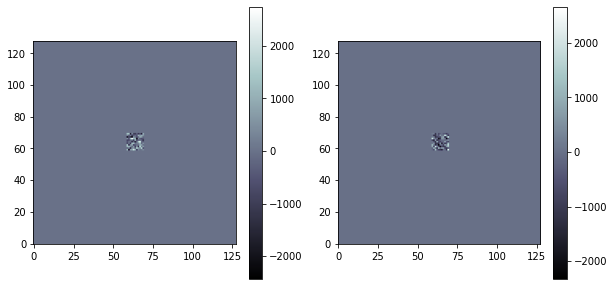

In [12]:
y_mod = true_model()
g1, g2 = y_mod[:y_mod.shape[0]//2], y_mod[y_mod.shape[0]//2:]
g1, g2 = np.reshape(g1, (128, 128)), np.reshape(g2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(g1, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(g2, origin='lower', cmap='bone')
plt.colorbar()

In [13]:
log_p, trace = log_density(model, (), {}, {'z': true_kappa})

In [14]:
log_p

DeviceArray(215575.2, dtype=float32)

In [15]:
trace

OrderedDict([('z',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.continuous.Normal at 0x7f07b22fd080>,
               'infer': {},
               'intermediates': [],
               'is_observed': False,
               'kwargs': {'rng_key': array([2205739499, 3850766070], dtype=uint32),
                'sample_shape': (32768,)},
               'name': 'z',
               'scale': None,
               'type': 'sample',
               'value': DeviceArray([-0.00774595, -0.00205239, -0.00947765, ...,  0.01021568,
                             0.0065422 ,  0.00988104], dtype=float32)}),
             ('y',
              {'args': (),
               'cond_indep_stack': [],
               'fn': <numpyro.distributions.continuous.Normal at 0x7f07b2089390>,
               'infer': {},
               'intermediates': [],
               'is_observed': False,
               'kwargs': {'rng_key': array([2336434339,  995697925], dtype=uint

In [16]:
obs_model = condition(model, {'y': shear})

In [17]:
y_mod = obs_model()

In [18]:
nuts_kernel = numpyro.infer.NUTS(obs_model)
mcmc = numpyro.infer.MCMC(nuts_kernel, 
                          num_warmup=100, 
                          num_samples=1000,
                          jit_model_args=True)

In [19]:
import time
start = time.time()
mcmc.run(rng_key)
print('\nMCMC elapsed time:', time.time() - start)

sample: 100%|██████████| 1100/1100 [01:41<00:00, 10.80it/s, 63 steps of size 6.50e-02. acc. prob=0.89]



MCMC elapsed time: 104.08678603172302


In [20]:
#mcmc.print_summary()

In [21]:
samples = mcmc.get_samples()
convergence = samples['z']

In [22]:
print(samples['z'].shape)

(1000, 32768)


In [23]:
convergence = np.mean(samples['z'][:, :], axis=0)
print(convergence.shape)

(32768,)


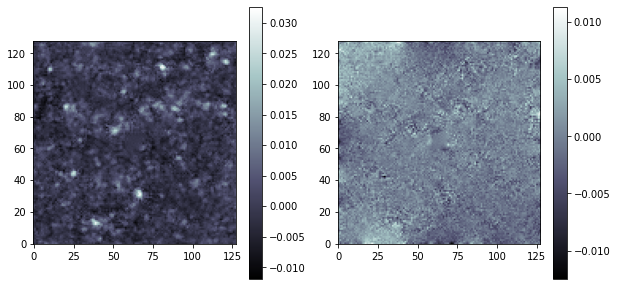

In [24]:
z1, z2 = convergence[:convergence.shape[0]//2], convergence[convergence.shape[0]//2:]
kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kE, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kB, origin='lower', cmap='bone')
plt.colorbar()
plt.savefig('hmc.png')

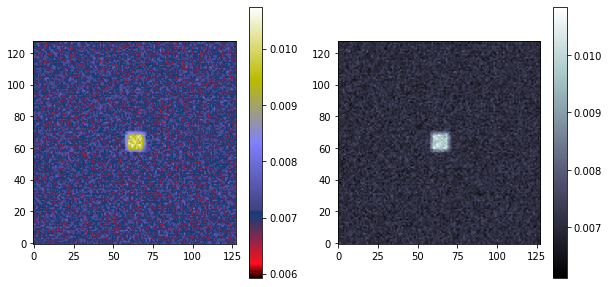

In [25]:
standatd_dev = np.std(samples['z'][:, :], axis=0)

z1, z2 = standatd_dev[:standatd_dev.shape[0]//2], standatd_dev[standatd_dev.shape[0]//2:]
kE, kB = np.reshape(z1, (128, 128)), np.reshape(z2, (128, 128))
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kE, origin='lower', cmap='gist_stern')
plt.colorbar()
plt.subplot(122)
plt.imshow(kB, origin='lower', cmap='bone')
plt.colorbar()

In [26]:
kappa_vi = np.load('jax-lensing/data/convergence_vi.npy')[0]
kappa_vi_E, kappa_vi_B = kappa_vi[:kappa_vi.shape[0]//2], kappa_vi[kappa_vi.shape[0]//2:]
kappa_vi_E, kappa_vi_B = np.reshape(kappa_vi_E, (128, 128)), np.reshape(kappa_vi_B, (128, 128))

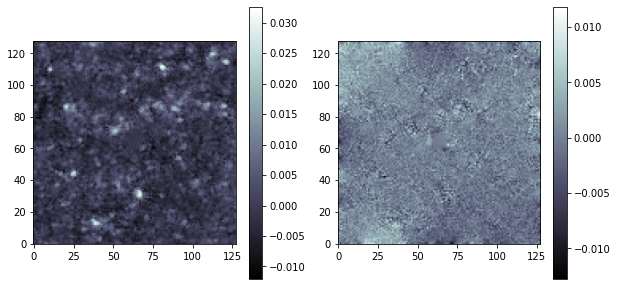

In [27]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(kappa_vi_E, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(kappa_vi_B, origin='lower', cmap='bone')
plt.colorbar()

Computing the bias
$$\frac{\|\kappa_{\mathrm{HMC}} - \kappa_{\mathrm{VI}}\|_2}{\|\kappa_{\mathrm{HMC}}\|_2}$$

In [28]:
b = np.linalg.norm(convergence - kappa_vi)/np.linalg.norm(convergence)
print(b)

0.22089863


Visualizing the bias

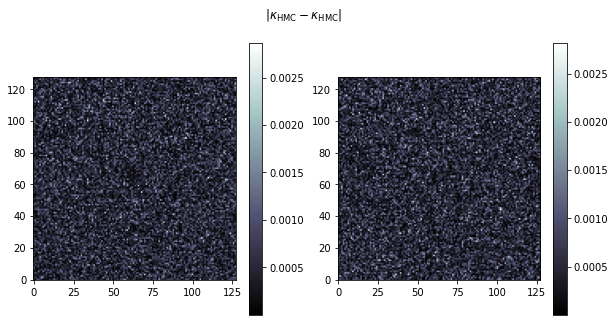

In [29]:
bias = np.abs(convergence - kappa_vi)
bias_E, bias_B = bias[:bias.shape[0]//2].reshape(128, 128), bias[bias.shape[0]//2:].reshape(128, 128)
plt.figure(figsize=(10, 5))
plt.suptitle('$\|\kappa_{\mathrm{HMC}} - \kappa_{\mathrm{HMC}}\|$')
plt.subplot(121)
plt.imshow(bias_E, origin='lower', cmap='bone')
plt.colorbar()
plt.subplot(122)
plt.imshow(bias_B, origin='lower', cmap='bone')
plt.colorbar()

We compute the power spectrum of the maps to investigate correlations. 

In [30]:
s = samples['z']
s -= np.mean(s, axis=0)
s /= np.std(s, axis=0)

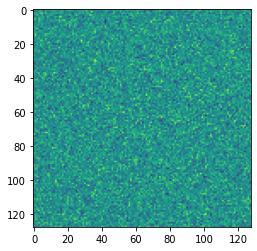

In [31]:
s_E = s[:,:s.shape[1]//2]
images = s_E[:,:].reshape(1000, 128, 128)
plt.imshow(images[0])

In [32]:
import scipy.stats as stats

def power_spectrum(images):
  Ab = []
  for image in images:
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image) ** 2

    kfreq = np.fft.fftfreq(128) * 128
    kfreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2)

    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, 64., 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])

    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes, statistic = "mean", bins = kbins)
    Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
  Ab.append(Abins)
  Abins = np.mean(np.array(Ab), 0)
  return kvals, Abins

In [33]:
kvals, Abins = power_spectrum(images[:1000])

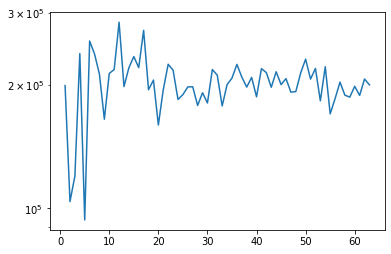

In [34]:
plt.plot(kvals, Abins/kvals/kvals)
plt.yscale('log')